In [1]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import dask
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import dask.array as da
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

In [3]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Aghulas_20200414',
 'Morroco_20201103',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Aghulas_20200426',
 'Scotland_20231109',
 'Aghulas_20200402',
 'Aghulas_20190515',
 'Aghulas_20200321']

In [4]:
scenario = 'Azores_20201127'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    era5_directory= 'era5_winds/',
    resolution_product=25_000,
    az_mask_cutoff=80_000,
    vx_sat=8000,
    PRF=4,
    grid_spacing=200,
    antenna_length=3.2,
    beam_pattern='phased_array',
    antenna_elements = 4,
    # era5_smoothing_window=15,
    # denoise = True,
    )

In [5]:
test.open_data()
test.querry_era5()
test.wdir_from_era5()
test.create_dataset()
test.create_beam_mask()
test.compute_scatt_eqv_backscatter()
test.compute_beam_pattern()
test.compute_leakage_velocity()
# test.compute_leakage_velocity_estimate()
# test.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202011.nc


In [6]:
10**(0.25/10)

1.0592537251772889

In [19]:
# find indexes of S1 scene that were cropped (outside full beam pattern)
idx_start = test.idx_az[0][test.az_mask_pixels_cutoff]
idx_end = test.idx_az[-1][test.az_mask_pixels_cutoff]

# create placeholder S1 data (pre-cropped)
new_nrcs = np.nan * np.ones_like(test.S1_file.NRCS_VV)
new_inc = np.nan * np.ones_like(test.S1_file.NRCS_VV)

# add speckle noise assuming a single look
if test._speckle_noise:
    noise_multiplier = test.speckle_noise(test.data.nrcs_scat.shape, random_state = test.random_state)
elif not test._speckle_noise:
    noise_multiplier = 1

single_look_nrcs = noise_multiplier * test.data.nrcs_scat

# interpolate estimated scatterometer data back to S1 grid size
slow_time_upsamp = np.linspace(test.data.slow_time[0], test.data.slow_time[-1], idx_end - idx_start) 
nrcs_scat_upsamp = single_look_nrcs.T.interp(slow_time = slow_time_upsamp)
inc_scat_upsamp = test.data.inc_scatt_eqv_cube.mean(dim='az_idx').T.interp(slow_time = slow_time_upsamp)

# apply cropping 
new_nrcs[idx_start: idx_end, :] = nrcs_scat_upsamp
new_inc[idx_start: idx_end, :] = inc_scat_upsamp

# copy existing object to avoid overwritting
self_copy = copy.deepcopy(test)

# replace real S1 data with scatterometer data interpolated to S1
self_copy.S1_file['NRCS_VV'] = (['azimuth_time', 'ground_range'], new_nrcs)
self_copy.S1_file['inc'] = (['azimuth_time', 'ground_range'], new_inc)

# define names of variables to consider and return
data_to_return = ['doppler_pulse_rg', 'doppler_pulse_rg_subscene', 'V_leakage_pulse_rg', 'V_leakage_pulse_rg_subscene', 'nrcs_scat', 'nrcs_scat_subscene']
data_to_return_new_names = [name + '_inverted' for name in data_to_return[:-2]] + ['nrcs_scat_w_noise', 'nrcs_scat_subscene_w_noise']
        
self_copy.create_dataset()
self_copy.create_beam_mask()
self_copy.compute_scatt_eqv_backscatter()
self_copy.compute_beam_pattern()

self_copy.data['dop_geom'] = (2 * self_copy.vx_sat * np.sin(self_copy.data['az_angle_wrt_boresight']) / self_copy.Lambda) # eq. 4.34 from Digital Procesing of Synthetic Aperture Radar Data by Ian G. Cummin 
self_copy.data['nrcs_weight'] = (self_copy.data['nrcs_scat_eqv'] / self_copy.data['nrcs_scat_eqv'].mean(dim=['az_idx'])) # NOTE weight calculated per azimuth line

# compute weighted received Doppler and resulting apparent LOS velocity
self_copy.data['dop_beam_weighted'] = self_copy.data['dop_geom'] * self_copy.data['beam'] * self_copy.data['nrcs_weight']
self_copy.data['V_leakage'] = self_copy.Lambda * self_copy.data['dop_beam_weighted'] / (2 * np.sin(np.deg2rad(self_copy.data['inc_scatt_eqv']))) # using the equivalent scatterometer incidence angle

# calculate scatt equivalent nrcs
self_copy.data['nrcs_scat'] = ((self_copy.data['nrcs'] * self_copy.data['beam']).sum(dim='az_idx', skipna=False) / self_copy.data['beam'].sum(dim='az_idx'))

# sum over azimuth to receive range-slow_time results
weight_rg = (self_copy.data['beam'] * self_copy.data['nrcs_weight']).sum(dim='az_idx', skipna=False)
receive_rg = self_copy.data[['dop_beam_weighted', 'V_leakage']].sum(dim='az_idx', skipna=False)
self_copy.data[['doppler_pulse_rg', 'V_leakage_pulse_rg']] = receive_rg / weight_rg

# add attribute
self_copy.data['V_leakage_pulse_rg'] = self_copy.data['V_leakage_pulse_rg'].assign_attrs(units= 'm/s', description = 'Line of sight velocity ')

# low-pass filter scatterometer data to subscene resolution
data_4subscene = ['doppler_pulse_rg', 'V_leakage_pulse_rg', 'nrcs_scat']
data_subscene = [name + '_subscene' for name in data_4subscene]
self_copy.data[data_subscene] = self_copy.data[data_4subscene].rolling(grg=self_copy.grg_N, slow_time=self_copy.slow_time_N, center=True).mean()
        

<xarray.DataArray ()>
array(0.69051426)

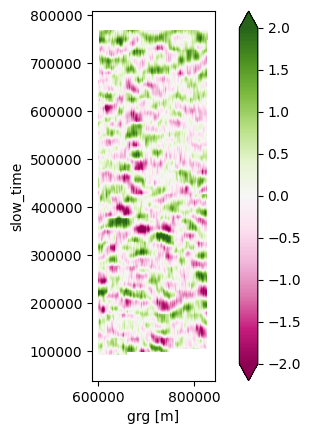

In [20]:
stride = 6
gradient_threshold = 10**11#0.5

nrcs_scatt_db = 10*np.log10(self_copy.data['nrcs_scat_subscene']).compute()
grad = nrcs_scatt_db.isel(slow_time = slice(None,-stride))- nrcs_scatt_db.roll(slow_time = stride)
masker = xr.where(abs(grad) > gradient_threshold, np.nan, 1)

t = (self_copy.data['V_leakage_pulse_rg'] * masker).rolling(grg=self_copy.grg_N, slow_time=self_copy.slow_time_N, center=True).mean()

plot_leakage_net_kwargs = {'vmin': -2, 'vmax': 2, 'cmap' : 'PiYG'}
ax = (test.data.V_leakage_pulse_rg_subscene - t).T.plot(robust = True, **plot_leakage_net_kwargs)
ax.axes.set_aspect('equal')

np.sqrt(np.mean((test.data.V_leakage_pulse_rg_subscene - t)**2)).compute()

In [9]:
test.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202011.nc


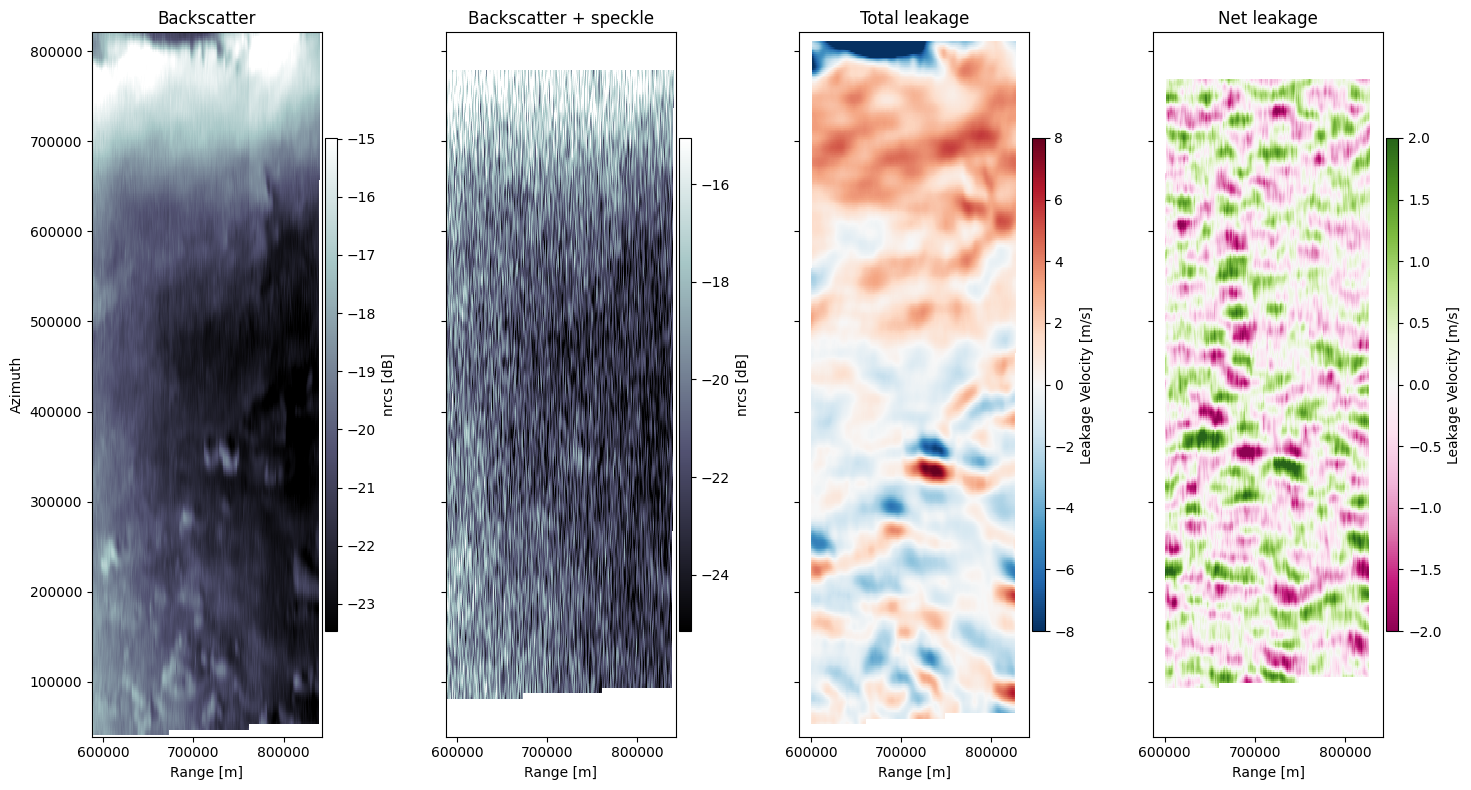

In [10]:
cbar_kwargs = {'shrink':0.7, 'aspect':40, 'pad' : 0.01, 'extend':'neither'}
plot_kwargs = {'robust': True}
plot_leakage_kwargs = {'vmin': -8, 'vmax': 8, 'cmap' : 'RdBu_r'}
plot_leakage_net_kwargs = {'vmin': -2, 'vmax': 2, 'cmap' : 'PiYG'}
label_kwargs = {'xlabel':'Range [m]', 'ylabel':'Azimuth [m]'}

net_leakage = test.data.V_leakage_pulse_rg_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
nx = 4; ny = 1
fig, axes = plt.subplots(ny, nx, figsize = (15, 8), sharex=True, sharey=True)

(10*np.log10(test.data.nrcs_scat)).T.plot(ax= axes[0], 
                                          **{'cmap': 'bone', **plot_kwargs},
                                          cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
(10*np.log10(test.data.nrcs_scat_w_noise)).T.plot(ax= axes[1], 
                                                  **{'cmap': 'bone', **plot_kwargs},
                                                  cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
test.data.V_leakage_pulse_rg_subscene.T.plot(ax= axes[2], 
                                             **{**plot_leakage_kwargs, **plot_kwargs},
                                             cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
net_leakage.T.plot(ax= axes[3],
                    **{**plot_leakage_net_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})


titles = ['Backscatter', 'Backscatter + speckle', 'Total leakage', 'Net leakage']
x_labels = ['Range [m]'] * nx
y_labels = ['Azimuth'] + [''] * (nx - ny)
_ = [ax.axes.set_title(i) for ax, i in zip(axes.ravel(), titles)]
_ = [ax.axes.set_xlabel(i) for ax, i in zip(axes.ravel(), x_labels)]
_ = [ax.axes.set_ylabel(i) for ax, i in zip(axes.ravel(), y_labels)]
_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()]

plt.tight_layout()

In [11]:
np.sqrt(np.mean(net_leakage**2))

<xarray.DataArray ()>
array(0.6795087, dtype=float32)